<a href="https://colab.research.google.com/github/tasyaa04/datascience/blob/main/PetBreed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
###DO NOT EDIT THIS CODE
################################################################################################################################

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt

# GPUs are 3x faster than CPU. Better to use if it is available 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Loss Function
loss_function = nn.CrossEntropyLoss()

# This function returns the number of parameters in the model
def num_params(model):
  return sum([p.numel() for p in model.parameters()])

# Define a Training Function. This function will: compute the forward pass, backpropagate,
# update the weights, and repeat the steps for a given number of epochs. At each epoch, 
# it will output the training loss and test loss at every step
def train(epochs, model, trainloader, testloader, optimizer, loss_function):
  for epoch in range(epochs):
    loss_epoch = np.array([])
    train_correct, train_total = 0, 0
    test_correct, test_total = 0, 0

    for data, labels in trainloader:
      # convert into GPU objects if needed
      input_data = data.to(device)
      labels = labels.to(device)

      # forward pass
      predict = model(input_data)
      
      # backward pass
      loss = loss_function(predict, labels)
      optimizer.zero_grad()
      loss.backward()

      # update parameters (weights and biases)
      optimizer.step()

      # store progress
      loss_epoch = np.append(loss_epoch, loss.item())

    # evaluate test accuracy
    for data, labels in testloader:
      input_data = data.to(device)
      labels = labels.to(device)
      predict = model(input_data)
      for i, out in enumerate(predict):
        pred = torch.argmax(out)
        if pred == labels[i]:
          test_correct+=1
        test_total+=1

    test_accuracy = test_correct/test_total    
  
    print('epoch [{}/{}], training loss:{:.4f}, test accuracy:{:.4f}'.format(epoch+1, epochs, np.mean(loss_epoch), test_accuracy))
################################################################################################################################

In [3]:
datasets.utils.download_url('https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz', '.')

Using downloaded and verified file: ./oxford-iiit-pet.tgz


In [4]:
import tarfile

with tarfile.open('./oxford-iiit-pet.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [5]:
from torch.utils.data import Dataset
import os

DATA_DIR = './data/oxford-iiit-pet/images'

files = os.listdir(DATA_DIR)
files[:5]

['boxer_126.jpg',
 'pug_107.jpg',
 'keeshond_193.jpg',
 'havanese_120.jpg',
 'leonberger_126.jpg']

In [6]:
def parse_breed(fname):
    parts = fname.split('_')
    return ' '.join(parts[:-1])

In [7]:
from PIL import Image

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [8]:
class PetsDataset(Dataset):
    def __init__(self, root, transform):
        super().__init__()
        self.root = root
        self.files = [fname for fname in os.listdir(root) if fname.endswith('.jpg')]
        self.classes = list(set(parse_breed(fname) for fname in files))
        self.transform = transform
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        fpath = os.path.join(self.root, fname)
        img = self.transform(open_image(fpath))
        class_idx = self.classes.index(parse_breed(fname))
        return img, class_idx

In [9]:
import torchvision.transforms as T

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
dataset = PetsDataset(DATA_DIR, T.Compose([T.Resize(img_size), 
                                           T.Pad(8, padding_mode='reflect'),
                                           T.RandomCrop(img_size), 
                                           T.ToTensor(), 
                                           T.Normalize(*imagenet_stats)]))

In [10]:
len(dataset)

7390

In [11]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Label: keeshond (24)


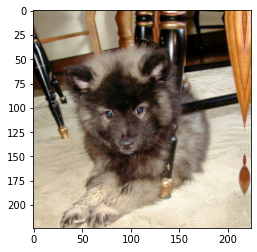

In [12]:
show_image(*dataset[2])

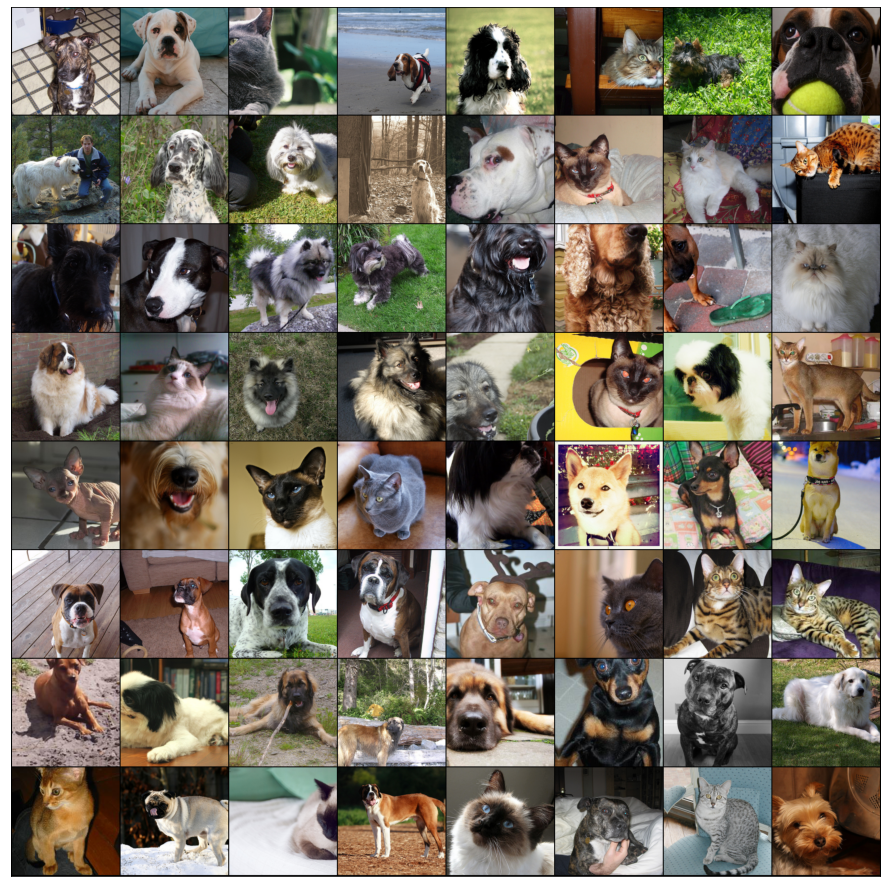

In [13]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

test_pct = 0.1
test_size = int(test_pct * len(dataset))

train_ds, test_ds = random_split(dataset, [len(dataset) - test_size, test_size])
batch_size = 256

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=0, pin_memory=True)

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *imagenet_stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break


show_batch(train_dl)

In [14]:
for data, labels in train_dl:
  print(data[0].size())
  print(labels[0])
  break

torch.Size([3, 224, 224])
tensor(18)


In [17]:
learning_rate = 10e-3
weight_decay = 10e-5
n_epochs = 10

# neural network
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    ### Define Layers
    self.conv1 = nn.Conv2d(3, 1, 7)
    self.fc1 = nn.Linear(47524, 100)
    self.fc2 = nn.Linear(100, 117)
    self.fc3 = nn.Linear(117, 37)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = torch.sigmoid(x)
    x = self.fc2(x)
    x = torch.sigmoid(x)
    x = self.fc3(x)
    x = torch.sigmoid(x)
    return x
  
# Every time you edit the neural network, you'll have to update this cell
# Create model object
model = NeuralNetwork().to(device)

# Loads Adam optimizer, which implements a version of gradient descent
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [18]:
train(n_epochs, model, train_dl, test_dl, optimizer, loss_function)

epoch [1/10], training loss:3.6189, test accuracy:0.0311
epoch [2/10], training loss:3.6097, test accuracy:0.0162
epoch [3/10], training loss:3.5976, test accuracy:0.0271
epoch [4/10], training loss:3.5809, test accuracy:0.0365
epoch [5/10], training loss:3.5717, test accuracy:0.0433
epoch [6/10], training loss:3.5623, test accuracy:0.0460
epoch [7/10], training loss:3.5650, test accuracy:0.0392
epoch [8/10], training loss:3.5662, test accuracy:0.0298
epoch [9/10], training loss:3.5665, test accuracy:0.0325
epoch [10/10], training loss:3.5637, test accuracy:0.0514
